读取数据，确认字段

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

plt.style.use("seaborn-v0_8")

In [2]:
BASE_DIR = Path.cwd()          # 当前项目根目录
DATA_DIR = BASE_DIR / "data"   # 确保 train.csv, test.csv 在这里

train = pd.read_csv(DATA_DIR / "train.csv")
test  = pd.read_csv(DATA_DIR / "test.csv")

train.shape, test.shape

((593994, 13), (254569, 12))

In [3]:
train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


标签分布（检查是不是不平衡）

In [5]:
target_col = "loan_paid_back"
id_col = "id"

counts = train[target_col].value_counts()
ratio = train[target_col].value_counts(normalize=True)

print(counts)
print(ratio)

loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64
loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64


确认缺失值(无缺失，数据很干净)

In [6]:
train.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

明确数值 & 类别特征列表

In [7]:
num_cols = [
    "annual_income",
    "debt_to_income_ratio",
    "credit_score",
    "loan_amount",
    "interest_rate",
]

cat_cols = [
    "gender",
    "marital_status",
    "education_level",
    "employment_status",
    "loan_purpose",
    "grade_subgrade",
]

print("数值特征:", num_cols)
print("类别特征:", cat_cols)

数值特征: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
类别特征: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


EDA图

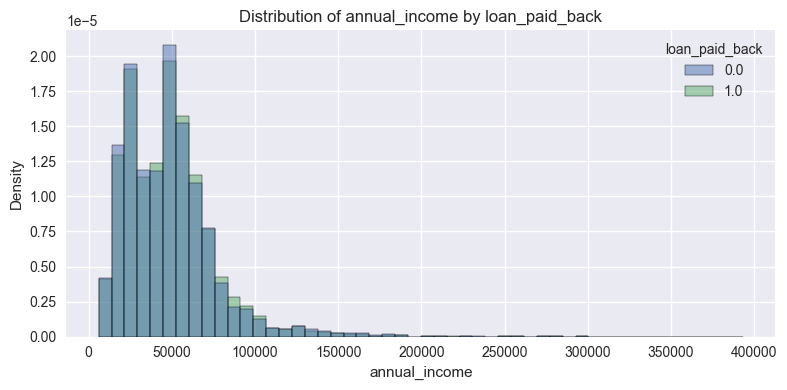

In [8]:
#年收入 vs 是否还清贷款
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(
    data=train,
    x="annual_income",
    bins=50,
    hue=target_col,
    stat="density",
    common_norm=False
)
plt.title("Distribution of annual_income by loan_paid_back")
plt.tight_layout()
plt.show()

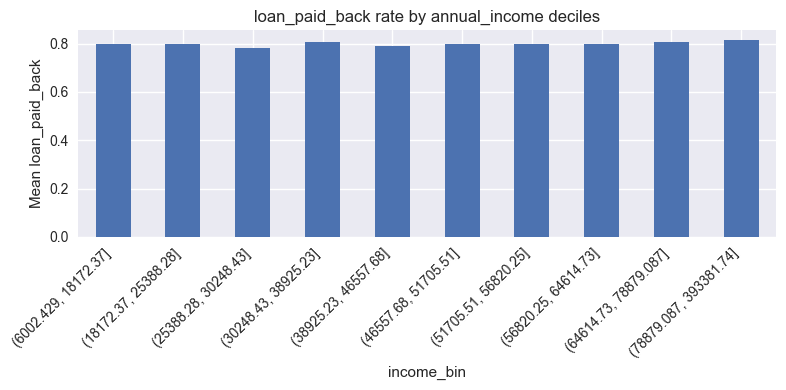

In [10]:
#不同收入区间的还清概率
train["income_bin"] = pd.qcut(train["annual_income"], q=10, duplicates="drop")
grouped_income = train.groupby("income_bin", observed=False)[target_col].mean()

plt.figure(figsize=(8, 4))
grouped_income.plot(kind="bar")
plt.ylabel("Mean loan_paid_back")
plt.title("loan_paid_back rate by annual_income deciles")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

train.drop(columns=["income_bin"], inplace=True)

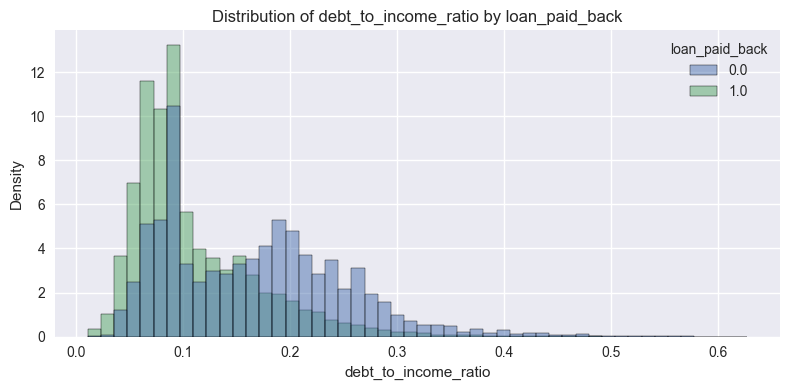

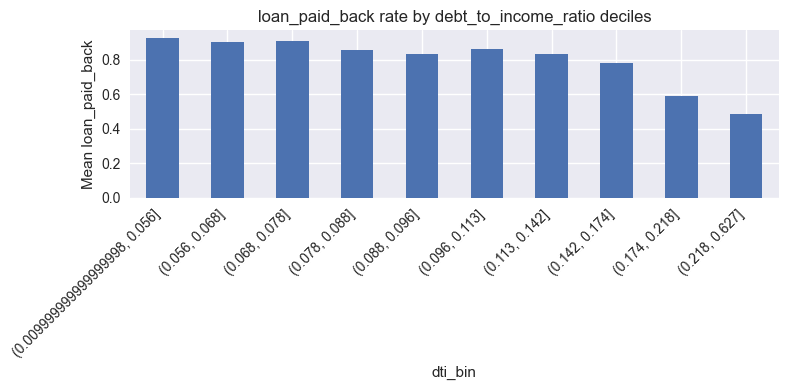

In [12]:
#债务收入比（debt_to_income_ratio） vs 标签
plt.figure(figsize=(8, 4))
sns.histplot(
    data=train,
    x="debt_to_income_ratio",
    bins=50,
    hue=target_col,
    stat="density",
    common_norm=False
)
plt.title("Distribution of debt_to_income_ratio by loan_paid_back")
plt.tight_layout()
plt.show()

train["dti_bin"] = pd.qcut(train["debt_to_income_ratio"], q=10, duplicates="drop")
grouped_dti = train.groupby("dti_bin", observed=False)[target_col].mean()

plt.figure(figsize=(8, 4))
grouped_dti.plot(kind="bar")
plt.ylabel("Mean loan_paid_back")
plt.title("loan_paid_back rate by debt_to_income_ratio deciles")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

train.drop(columns=["dti_bin"], inplace=True)

loan_purpose
Debt consolidation    324695
Other                  63874
Car                    58108
Home                   44118
Education              36641
Business               35303
Medical                22806
Vacation                8449
Name: count, dtype: int64


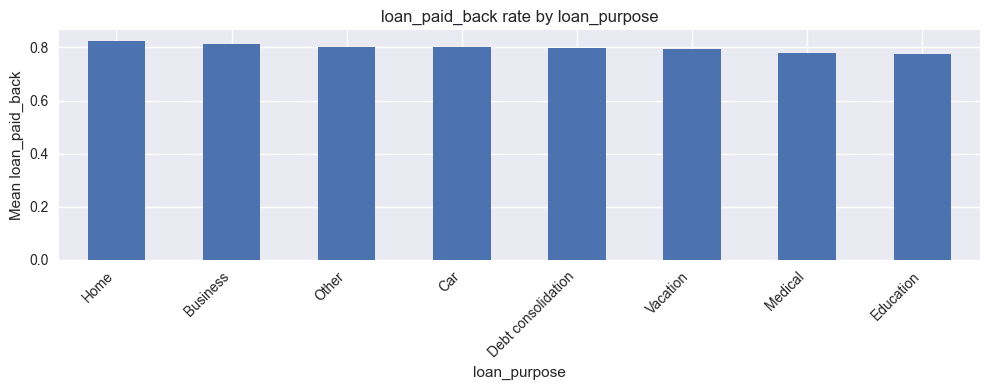

In [14]:
#一个类别特征：比如 loan_purpose
cat_feature = "loan_purpose"

print(train[cat_feature].value_counts().head(10))

purpose_rate = (
    train.groupby(cat_feature)[target_col]
         .mean()
         .sort_values(ascending=False)
)

plt.figure(figsize=(10, 4))
purpose_rate.plot(kind="bar")
plt.ylabel("Mean loan_paid_back")
plt.title("loan_paid_back rate by loan_purpose")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()